# Importing Libraries

In [84]:
import os
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, SimpleRNN
import keras_tuner

## Splitting the dataset

In [28]:
# loading the cleaned dataset
import zipfile

with zipfile.ZipFile('news_final.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [72]:
from ast import literal_eval
news_final = pd.read_csv("news_final", converters={'title': literal_eval,'all_text': literal_eval})

target = news_final['fake']
features = news_final[['title','all_text']]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.25) # 0.25 x 0.8 = 0.2, #20% valid

# Hypothesis 2: Testing Neural Network models

## Define Tokenizing, Padding, Plotting functions & Earlystopping

In [32]:
def tokenize(train_data,val_data,test_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data)

    train_data = tokenizer.texts_to_sequences(train_data)
    val_data = tokenizer.texts_to_sequences(val_data)
    test_data = tokenizer.texts_to_sequences(test_data)
    vocab = tokenizer.word_index
    return train_data,val_data,test_data,vocab

def pad(train_data,val_data,test_data,max_len):
    train_data = pad_sequences(train_data, padding='post', maxlen=max_len)
    val_data = pad_sequences(val_data, padding='post', maxlen=max_len)
    test_data = pad_sequences(test_data, padding='post', maxlen=max_len)
    return train_data,val_data,test_data

def plotHistory(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = history.epoch

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## 1. Training on titles only

In [36]:
X_train1, X_val1, X_test1, vocab1 = tokenize(X_train['title'], X_val['title'], X_test['title'])
max_vocab1 = len(vocab1) + 1 # Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
print("Vocab Size for Titles: {}".format(max_vocab1))

# get length of longest title and pad all shorter titles to match length
max_len1 = max([len(x) for x in X_train1] + [len(x) for x in X_test1])
X_train1, X_val1, X_test1 = pad(X_train1, X_val1, X_test1, max_len1)
print("Max Title Length: {}".format(max_len1))

Vocab Size for Titles: 19388
Max Title Length: 34


### Model 1: Training a simple RNN model on titles only

In [37]:
rnn_title_model = Sequential([
    Embedding(max_vocab1, 100, input_length=max_len1),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_title_model.summary()

2022-11-08 01:26:20.900617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           1938800   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              58624     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,997,681
Trainable params: 1,997,681
Non-trainable params: 0
_________________________________________________________________


In [38]:
%%time
rnn_title_history = rnn_title_model.fit(X_train1, y_train, epochs=10, 
                    validation_data=(X_val1, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 38s 45ms/step - loss: 0.3057 - accuracy: 0.8704 - val_loss: 0.1896 - val_accuracy: 0.9313
Epoch 2/10
774/774 [==============================] - 41s 53ms/step - loss: 0.1133 - accuracy: 0.9599 - val_loss: 0.1695 - val_accuracy: 0.9378
Epoch 3/10
774/774 [==============================] - 43s 55ms/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.1813 - val_accuracy: 0.9383
Epoch 4/10
774/774 [==============================] - 45s 58ms/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.1870 - val_accuracy: 0.9430
CPU times: user 4min 32s, sys: 1min 36s, total: 6min 9s
Wall time: 2min 46s


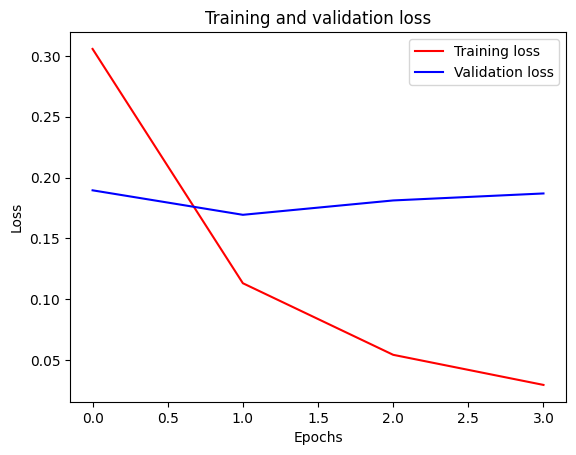

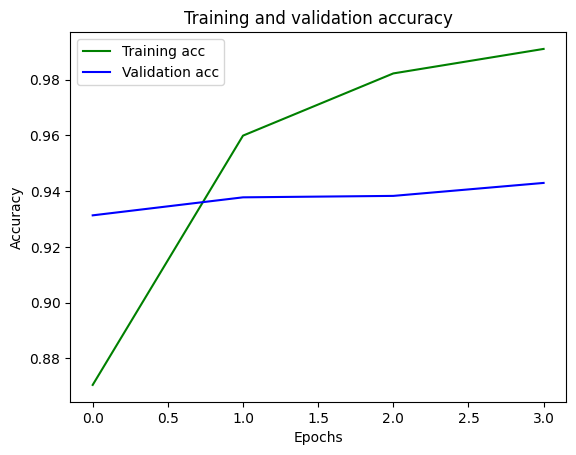

In [39]:
plotHistory(rnn_title_history)

In [40]:
rnn_title_model.evaluate(X_train1, y_train)

725/725 [==============================] - 3s 5ms/step - loss: 0.0579 - accuracy: 0.9818


[0.057937514036893845, 0.9818487763404846]

In [41]:
rnn_title_model.evaluate(X_val1, y_val)

242/242 [==============================] - 1s 5ms/step - loss: 0.1695 - accuracy: 0.9378


[0.16945888102054596, 0.9377909898757935]

In [42]:
rnn_title_model.evaluate(X_test1, y_test)

242/242 [==============================] - 1s 5ms/step - loss: 0.1690 - accuracy: 0.9390


[0.16899777948856354, 0.9389550089836121]

### Model 2: Training an LSTM model on titles only

In [43]:
lstm_title_model = Sequential([
    Embedding(max_vocab1, 100, input_length=max_len1),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_title_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_title_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 100)           1938800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,173,553
Trainable params: 2,173,553
Non-trainable params: 0
_________________________________________________________________


In [44]:
%%time
lstm_title_history = lstm_title_model.fit(X_train1, y_train, epochs=10, 
                    validation_data=(X_val1, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 101s 124ms/step - loss: 0.3939 - accuracy: 0.8013 - val_loss: 0.1616 - val_accuracy: 0.9359
Epoch 2/10
774/774 [==============================] - 110s 143ms/step - loss: 0.1225 - accuracy: 0.9543 - val_loss: 0.1505 - val_accuracy: 0.9422
Epoch 3/10
774/774 [==============================] - 112s 145ms/step - loss: 0.0726 - accuracy: 0.9752 - val_loss: 0.1412 - val_accuracy: 0.9470
Epoch 4/10
774/774 [==============================] - 95s 123ms/step - loss: 0.0460 - accuracy: 0.9861 - val_loss: 0.1748 - val_accuracy: 0.9414
Epoch 5/10
774/774 [==============================] - 90s 116ms/step - loss: 0.0280 - accuracy: 0.9926 - val_loss: 0.1884 - val_accuracy: 0.9445
CPU times: user 16min 31s, sys: 4min 6s, total: 20min 37s
Wall time: 8min 28s


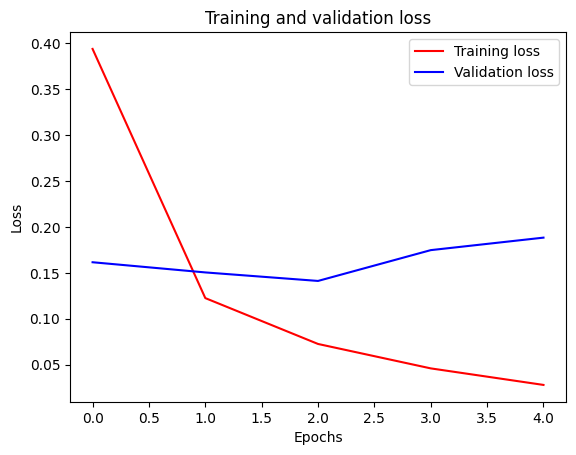

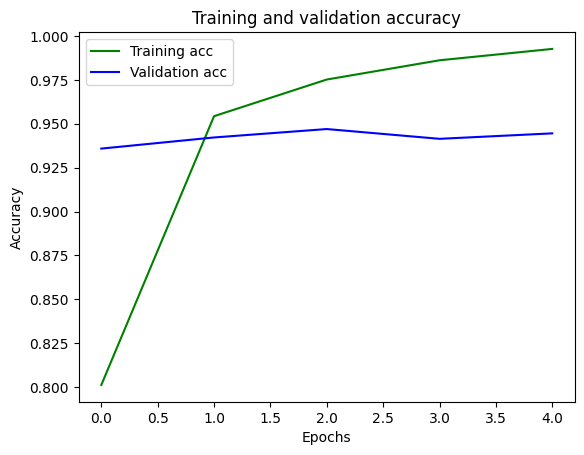

In [45]:
plotHistory(lstm_title_history)

In [46]:
lstm_title_model.evaluate(X_train1, y_train)

725/725 [==============================] - 16s 22ms/step - loss: 0.0373 - accuracy: 0.9896


[0.0372762568295002, 0.9895662665367126]

In [47]:
lstm_title_model.evaluate(X_val1, y_val)

242/242 [==============================] - 6s 23ms/step - loss: 0.1412 - accuracy: 0.9470


[0.14121194183826447, 0.9469736218452454]

In [48]:
lstm_title_model.evaluate(X_test1, y_test)

242/242 [==============================] - 6s 23ms/step - loss: 0.1477 - accuracy: 0.9468


[0.14769607782363892, 0.9468442797660828]

## 2. Training on all text (title + text)

### Training the word2vec model on the dataset

In [75]:
X_train2 = X_train['all_text']
X_val2 = X_val['all_text']
X_test2 = X_test['all_text']

In [76]:
 # all tokens generated in the first article
print(X_train2[0])

['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'trump', 'realdonaldtrump', 'december', 'trump', 'tweet', 'went', 'welll', 'expect', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberis

In [77]:
%%time
# training word2vec on the 'text' corpus to form the embedding layer
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(
    sentences = X_train2,
    vector_size = EMBEDDING_DIM,
    window = 5,
    min_count = 1
)

CPU times: user 1min 31s, sys: 767 ms, total: 1min 32s
Wall time: 35.2 s


In [78]:
num = len(w2v.wv)
print('There are a total of %d words in the vocabulary of our trained word2vec model.' % num)

There are a total of 108281 words in the vocabulary of our trained word2vec model.


In [79]:
w2v.wv["donald"]

array([-1.6314154 ,  1.4955556 , -1.4407815 ,  1.5171522 , -2.5575368 ,
       -0.56538314, -1.3531022 ,  0.9889945 , -1.2652371 ,  3.2407134 ,
       -0.92265886, -0.25792125, -0.01475068,  1.3487247 , -1.5101459 ,
        2.3005598 , -0.71978086, -2.933771  ,  3.6756122 , -1.132561  ,
        0.51757133,  0.96989316, -0.45367733, -0.25192797,  2.5143518 ,
       -3.2115    , -3.158529  ,  0.08550263, -0.3493004 ,  0.64664286,
       -0.6683444 ,  2.1531692 ,  1.9030342 ,  1.8107902 ,  1.3795037 ,
        2.1782067 , -1.0706915 ,  1.8116537 ,  0.07430641, -0.31939843,
        1.53058   , -0.2774306 ,  0.5602655 ,  0.561102  , -0.94820774,
       -0.5505203 , -0.8152316 ,  0.7697111 ,  0.0087425 , -0.16676944,
        1.5863199 ,  1.9513414 ,  0.2738626 ,  0.7467672 , -2.7104578 ,
       -0.20833962, -2.2161636 ,  0.3763268 ,  0.39972454, -1.7881414 ,
        0.8305237 ,  2.7834113 ,  1.5774425 ,  1.1892978 , -1.0226973 ,
       -2.1337926 ,  1.6630524 ,  0.21934755,  1.9383119 , -2.41

In [80]:
w2v.wv.most_similar("trump")

[('president-elect', 0.646259069442749),
 ('instead', 0.5322952270507812),
 ('conway', 0.5134116411209106),
 ('loose-lipped', 0.5096831321716309),
 ('course', 0.5056433081626892),
 ('actually', 0.49975472688674927),
 ('fact', 0.49385425448417664),
 ('wherevers', 0.4834011495113373),
 ('obama', 0.4752030372619629),
 ('exactly', 0.4715747535228729)]

### Preparing the neural network model inputs

In [81]:
X_train2, X_val2, X_test2, vocab2 = tokenize(X_train2, X_val2, X_test2)
max_vocab2 = len(vocab2) + 1
print("Vocab Size for All Text: {}".format(max_vocab2))

Vocab Size for All Text: 108282


In [82]:
# all token indexes generated from the first article
print(X_train2[0])

[596, 4, 1478, 9658, 1326, 836, 378, 211, 7, 20, 11, 2, 596, 4, 913, 1478, 945, 4, 3491, 1326, 1282, 1137, 6929, 1195, 378, 211, 7, 142, 360, 5112, 1478, 1326, 9, 2265, 2438, 39808, 253, 1270, 459, 393, 3454, 5946, 874, 3455, 20, 11, 2, 78, 337, 218]


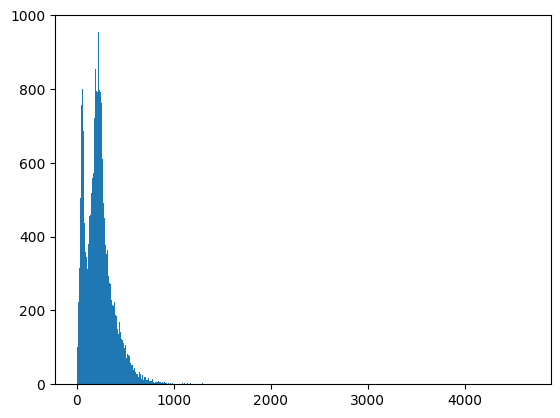

In [85]:
article_lens = np.array([len(index) for index in X_train2])
plt.hist(article_lens, bins=500)
plt.show()

In [86]:
len_1000 = article_lens[article_lens < 1000]
print('%d out of %d articles have less than 1000 words' % (len(len_1000),len(article_lens)))

23102 out of 23194 articles have less than 1000 words


<li>Since the inputs to the neural network have to be of the same size, we have to pad each article in the dataset.</li>
<li>Since the majority of articles have less than 1000 words, we pad shorter news articles and truncate longer articles.</li>

In [87]:
max_len2 = 1000
X_train2, X_val2, X_test2 = pad(X_train2, X_val2, X_test2, max_len2)
print("Max All Text Length: {}".format(max_len2))

Max All Text Length: 1000


In [88]:
# creating a weight matrix to retain weights learned by word2vec in the embedding layer later on
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # create weight matrix with number of rows = vocab_size and number of columns = number of embedding dimensions
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # for each word in the vocab, store its vector created by the word2vec model
    for word, row_index in vocab.items():
        weight_matrix[row_index] = model.wv[word]
    return weight_matrix

In [89]:
embedding_vectors = get_weight_matrix(w2v, vocab2)

### Model 3: Training a simple RNN model on all text

In [91]:
rnn_alltext_model = Sequential([
    Embedding(max_vocab2, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len2, trainable=False),
    Bidirectional(SimpleRNN(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

rnn_alltext_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         10828200  
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              58624     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,887,081
Trainable params: 58,881
Non-trainable params: 10,828,200
_________________________________________________________________


In [92]:
%%time
rnn_alltext_history = rnn_alltext_model.fit(X_train2, y_train, epochs=10, 
                                validation_data=(X_val2, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 317s 407ms/step - loss: 0.3345 - accuracy: 0.8503 - val_loss: 0.1741 - val_accuracy: 0.9422
Epoch 2/10
774/774 [==============================] - 288s 372ms/step - loss: 0.1764 - accuracy: 0.9446 - val_loss: 0.1468 - val_accuracy: 0.9506
Epoch 3/10
774/774 [==============================] - 292s 377ms/step - loss: 0.1576 - accuracy: 0.9520 - val_loss: 0.1450 - val_accuracy: 0.9529
Epoch 4/10
774/774 [==============================] - 301s 389ms/step - loss: 0.1458 - accuracy: 0.9553 - val_loss: 0.1342 - val_accuracy: 0.9582
Epoch 5/10
774/774 [==============================] - 280s 362ms/step - loss: 0.1442 - accuracy: 0.9565 - val_loss: 0.1287 - val_accuracy: 0.9572
Epoch 6/10
774/774 [==============================] - 291s 376ms/step - loss: 0.1315 - accuracy: 0.9602 - val_loss: 0.1254 - val_accuracy: 0.9599
Epoch 7/10
774/774 [==============================] - 283s 365ms/step - loss: 0.1247 - accuracy: 0.9631 - val_loss: 0.1926 -

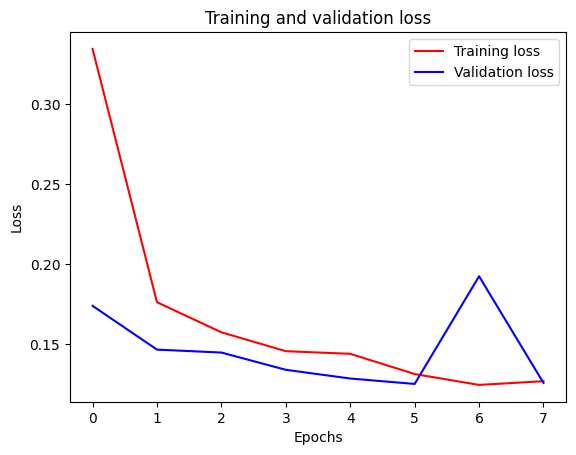

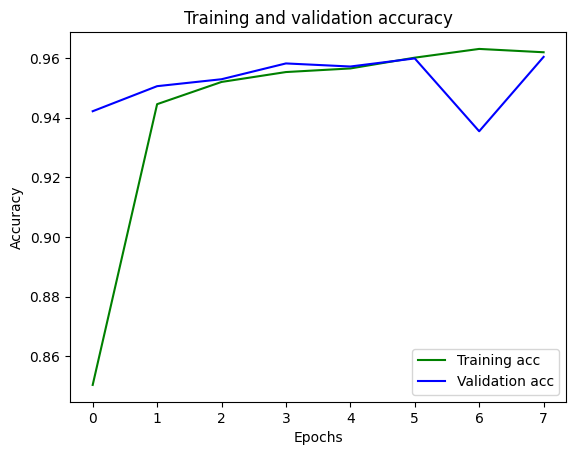

In [93]:
plotHistory(rnn_alltext_history)

In [94]:
rnn_alltext_model.evaluate(X_train2, y_train)

725/725 [==============================] - 69s 96ms/step - loss: 0.1136 - accuracy: 0.9660


[0.11355914920568466, 0.966025710105896]

In [95]:
rnn_alltext_model.evaluate(X_val2, y_val)

242/242 [==============================] - 26s 109ms/step - loss: 0.1254 - accuracy: 0.9599


[0.12535838782787323, 0.9599068760871887]

In [100]:
rnn_alltext_model.evaluate(X_test2, y_test)

242/242 [==============================] - 22s 90ms/step - loss: 0.1310 - accuracy: 0.9585


[0.1310245543718338, 0.9584842324256897]

### Model 4: Training an LSTM model on all text

In [101]:
lstm_alltext_model = Sequential([
    Embedding(max_vocab2, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len2, trainable=False),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_alltext_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_alltext_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         10828200  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 11,062,953
Trainable params: 234,753
Non-trainable params: 10,828,200
_________________________________________________________________


In [99]:
%%time
lstm_alltext_history = lstm_alltext_model.fit(X_train2, y_train, epochs=10, 
                                validation_data=(X_val2, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
774/774 [==============================] - 1350s 2s/step - loss: 0.1743 - accuracy: 0.9409 - val_loss: 0.1068 - val_accuracy: 0.9634
Epoch 2/10
774/774 [==============================] - 1257s 2s/step - loss: 0.0824 - accuracy: 0.9726 - val_loss: 0.0672 - val_accuracy: 0.9768
Epoch 3/10
774/774 [==============================] - 1222s 2s/step - loss: 0.0722 - accuracy: 0.9763 - val_loss: 0.0578 - val_accuracy: 0.9794
Epoch 4/10
774/774 [==============================] - 1230s 2s/step - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.0617 - val_accuracy: 0.9785
Epoch 5/10
774/774 [==============================] - 1226s 2s/step - loss: 0.0571 - accuracy: 0.9812 - val_loss: 0.0840 - val_accuracy: 0.9758
CPU times: user 4h 59min 12s, sys: 59min 43s, total: 5h 58min 55s
Wall time: 1h 44min 45s


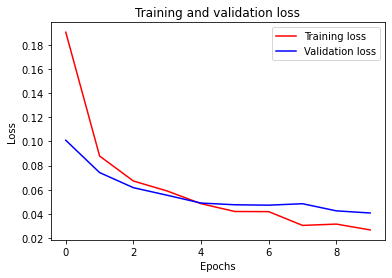

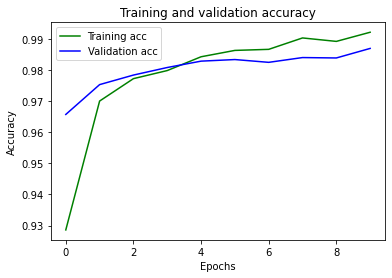

In [103]:
plotHistory(lstm_alltext_history)

In [104]:
lstm_alltext_model.evaluate(X_train2, y_train)

734/734 [==============================] - 29s 39ms/step - loss: 0.0191 - accuracy: 0.9943


[0.01908102259039879, 0.9943314790725708]

In [105]:
lstm_alltext_model.evaluate(X_val2, y_val)

245/245 [==============================] - 10s 40ms/step - loss: 0.0408 - accuracy: 0.9870


[0.0407821387052536, 0.9869582056999207]

In [106]:
lstm_alltext_model.evaluate(X_test2, y_test)

245/245 [==============================] - 10s 39ms/step - loss: 0.0428 - accuracy: 0.9873


[0.04282530024647713, 0.9873417615890503]

### Hyperparameter tuning for LSTM model for all text

In [102]:
def hyperparameterTuning(hp): #https://keras.io/api/keras_tuner/hyperparameters/
    model = Sequential([
        Embedding(max_vocab2, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len2, trainable=False),
        Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=192, step=64))), #https://keras.io/api/layers/recurrent_layers/simple_rnn/
        Dropout(rate=hp.Float('rate', min_value=0.3, max_value=0.7, step=0.2)), #https://keras.io/api/layers/regularization_layers/dropout/
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    return model

In [103]:
#https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
tuner = keras_tuner.BayesianOptimization(hyperparameterTuning,
                              objective='val_loss',
                             directory='lstm_tuner2')

In [105]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner.search(X_train2, y_train, epochs=10, 
            validation_data=(X_val2, y_val), batch_size=30, 
            shuffle=True, callbacks=[early_stop])

In [147]:
tuner.results_summary()

Results summary
Results in lstm_tuner2\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.03331878408789635
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.039939410984516144
Trial summary
Hyperparameters:
units: 128
rate: 0.5
Score: 0.041870806366205215
Trial summary
Hyperparameters:
units: 128
rate: 0.5
Score: 0.04192085936665535
Trial summary
Hyperparameters:
units: 128
rate: 0.7
Score: 0.04503205046057701
Trial summary
Hyperparameters:
units: 192
rate: 0.5
Score: 0.04686621576547623
Trial summary
Hyperparameters:
units: 64
rate: 0.3
Score: 0.04874274879693985
Trial summary
Hyperparameters:
units: 192
rate: 0.3
Score: 0.05330261215567589
Trial summary
Hyperparameters:
units: 64
rate: 0.7
Score: 0.05358147248625755
Trial summary
Hyperparameters:
units: 192
rate: 0.7
Score: 0.05900872126221657


In [148]:
best_lstm_model = tuner.get_best_models(num_models=1)[0]

In [149]:
best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         9046600   
                                                                 
 bidirectional (Bidirectiona  (None, 384)              450048    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 9,497,033
Trainable params: 450,433
Non-trainable params: 9,046,600
_________________________________________________________________


In [150]:
best_lstm_model.evaluate(X_train2, y_train)

734/734 [==============================] - 31s 41ms/step - loss: 0.0210 - accuracy: 0.9932


[0.02104427106678486, 0.9932233691215515]

In [151]:
best_lstm_model.evaluate(X_val2, y_val)

245/245 [==============================] - 10s 40ms/step - loss: 0.0333 - accuracy: 0.9890


[0.03331877291202545, 0.9890039563179016]

In [152]:
best_lstm_model.evaluate(X_test2, y_test)

245/245 [==============================] - 10s 40ms/step - loss: 0.0442 - accuracy: 0.9873


[0.04415591061115265, 0.9873417615890503]